In [1]:
import os
train_dir = "./train"
train_dogs_dir = f'{train_dir}/dogs'
train_cats_dir = f'{train_dir}/cats'
val_dir = "./val"
val_dogs_dir = f'{val_dir}/dogs'
val_cats_dir = f'{val_dir}/cats'
print("Printing data dir")
print(os.listdir(".")) # Shows train, val folders are under data
print("Printing train dir")
print(os.listdir(train_dir)[:5]) 
print("Printing train dog dir")
print(os.listdir(train_dogs_dir)[:5]) # Check the (empty) folder exist
print("Printing train cat dir")
print(os.listdir(train_cats_dir)[:5]) # Check the (empty) folder exist
print("Printing val dir")
print(os.listdir(val_dir)[:5]) # Shows subfolder dogs and cats exist
print("Printing val dog dir")
print(os.listdir(val_dogs_dir)[:5]) # Check the (empty) folder exist
print("Printing val cat dir")
print(os.listdir(val_cats_dir)[:5]) # Check the (empty) folder exist

Printing data dir
['.ipynb_checkpoints', 'cats_dogs_no_transfer_learning - Copy.ipynb', 'cats_dogs_no_transfer_learning.ipynb', 'cat_dog_tutorial-Copy1.ipynb', 'checkpoint.tar', 'sample_submission.csv', 'test', 'test.zip', 'train', 'train.zip', 'val']
Printing train dir
['cats', 'dogs']
Printing train dog dir
['dog.0.jpg', 'dog.1.jpg', 'dog.10.jpg', 'dog.100.jpg', 'dog.1000.jpg']
Printing train cat dir
['cat.0.jpg', 'cat.1.jpg', 'cat.10.jpg', 'cat.100.jpg', 'cat.1000.jpg']
Printing val dir
['cats', 'dogs']
Printing val dog dir
['dog.5000.jpg', 'dog.5001.jpg', 'dog.5002.jpg', 'dog.5003.jpg', 'dog.5004.jpg']
Printing val cat dir
['cat.5000.jpg', 'cat.5001.jpg', 'cat.5002.jpg', 'cat.5003.jpg', 'cat.5004.jpg']


In [2]:
print(os.listdir('.'))

['.ipynb_checkpoints', 'cats_dogs_no_transfer_learning - Copy.ipynb', 'cats_dogs_no_transfer_learning.ipynb', 'cat_dog_tutorial-Copy1.ipynb', 'checkpoint.tar', 'sample_submission.csv', 'test', 'test.zip', 'train', 'train.zip', 'val']


In [3]:
import shutil
import re
files = os.listdir(train_dir)
# Move all train cat images to cats folder, dog images to dogs folder
for f in files:
    catSearchObj = re.search("cat", f)
    dogSearchObj = re.search("dog", f)
    if catSearchObj:
        shutil.move(f'{train_dir}/{f}', train_cats_dir)
    elif dogSearchObj:
        shutil.move(f'{train_dir}/{f}', train_dogs_dir)

In [4]:
print("Printing train dir") # shows cats, dogs subfolders only
print(os.listdir(train_dir)[:5])
print("Printing train dog dir") # there is now dog images in dogs folder
print(os.listdir(train_dogs_dir)[:5])
print("Printing train cat dir") # there is now cat images in cats folder
print(os.listdir(train_cats_dir)[:5])

Printing train dir
['cats', 'dogs']
Printing train dog dir
['dog.0.jpg', 'dog.1.jpg', 'dog.10.jpg', 'dog.100.jpg', 'dog.1000.jpg']
Printing train cat dir
['cat.0.jpg', 'cat.1.jpg', 'cat.10.jpg', 'cat.100.jpg', 'cat.1000.jpg']


In [5]:
files = os.listdir(train_dogs_dir)
for f in files:
    validationDogsSearchObj = re.search("5\d\d\d", f)
    if validationDogsSearchObj:
        shutil.move(f'{train_dogs_dir}/{f}', val_dogs_dir)
print("Printing val dog dir")
print(os.listdir(val_dogs_dir)[:5])

Printing val dog dir
['dog.5000.jpg', 'dog.5001.jpg', 'dog.5002.jpg', 'dog.5003.jpg', 'dog.5004.jpg']


In [6]:
files = os.listdir(train_cats_dir)
for f in files:
    validationCatsSearchObj = re.search("5\d\d\d", f)
    if validationCatsSearchObj:
        shutil.move(f'{train_cats_dir}/{f}', val_cats_dir)
print("Printing val cat dir")
print(os.listdir(val_cats_dir)[:5])

Printing val cat dir
['cat.5000.jpg', 'cat.5001.jpg', 'cat.5002.jpg', 'cat.5003.jpg', 'cat.5004.jpg']


In [7]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import math
print(torch.__version__)
plt.ion()   # interactive mode

1.7.1


In [8]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(5),
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(224, scale=(0.96, 1.0), ratio=(0.95, 1.05)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize([224,224]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [9]:
data_dir = '.'
CHECK_POINT_PATH = 'checkpoint.tar'
#SUBMISSION_FILE = 'submission.csv'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                              shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(class_names) # => ['cats', 'dogs']
print(f'Train image size: {dataset_sizes["train"]}')
print(f'Validation image size: {dataset_sizes["val"]}')

['cats', 'dogs']
Train image size: 23000
Validation image size: 2000


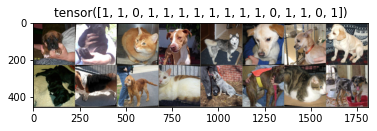

In [10]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
# Make a grid from batch
sample_train_images = torchvision.utils.make_grid(inputs)
imshow(sample_train_images, title=classes)

In [11]:
model_conv = torchvision.models.resnet50(pretrained=True)


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to C:\Users\alexa/.cache\torch\hub\checkpoints\resnet50-19c8e357.pth


In [12]:
for param in model_conv.parameters():
    param.requires_grad = False
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)
model_conv = model_conv.to(device)
model_conv.train()
criterion = nn.CrossEntropyLoss()
# Observe that only parameters of final layer are being optimized
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)


In [13]:
# Decay LR by a factor of 0.1 every 7 epochs
from torch.optim import lr_scheduler
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)


In [14]:
epochs = 10

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    exp_lr_scheduler.step()
    
    for data, label in dataloaders['train']:
        data = data.to(device)
        label = label.to(device)
        
        output = model_conv(data)
        loss = criterion(output, label)
        
        optimizer_conv.zero_grad()
        loss.backward()
        optimizer_conv.step()
        
        acc = ((output.argmax(dim=1) == label).float().mean())
        epoch_accuracy += acc/len(dataloaders['train'])
        epoch_loss += loss/len(dataloaders['train'])
        
    print('Epoch : {}, train accuracy : {}, train loss : {}'.format(epoch+1, epoch_accuracy,epoch_loss))
    
    
    with torch.no_grad():
        epoch_val_accuracy=0
        epoch_val_loss =0
        for data, label in dataloaders['val']:
            data = data.to(device)
            label = label.to(device)
            
            val_output = model_conv(data)
            val_loss = criterion(val_output,label)
            
            
            acc = ((val_output.argmax(dim=1) == label).float().mean())
            epoch_val_accuracy += acc/ len(dataloaders['val'])
            epoch_val_loss += val_loss/ len('val')
            
        print('Epoch : {}, val_accuracy : {}, val_loss : {}'.format(epoch+1, epoch_val_accuracy,epoch_val_loss))

C:\Users\alexa\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch : 1, train accuracy : 0.9570153951644897, train loss : 0.11037663370370865
Epoch : 1, val_accuracy : 0.9635003805160522, val_loss : 3.9086780548095703
Epoch : 2, train accuracy : 0.9689674973487854, train loss : 0.08207686990499496
Epoch : 2, val_accuracy : 0.961500346660614, val_loss : 4.201404571533203
Epoch : 3, train accuracy : 0.9696627259254456, train loss : 0.07726580649614334
Epoch : 3, val_accuracy : 0.9690002799034119, val_loss : 3.4719619750976562
Epoch : 4, train accuracy : 0.9703583121299744, train loss : 0.08092609792947769
Epoch : 4, val_accuracy : 0.9695002436637878, val_loss : 3.6176905632019043
Epoch : 5, train accuracy : 0.9711834788322449, train loss : 0.07293005287647247
Epoch : 5, val_accuracy : 0.9590004086494446, val_loss : 4.281435966491699
Epoch : 6, train accuracy : 0.971662163734436, train loss : 0.07161376625299454
Epoch : 6, val_accuracy : 0.9700003266334534, val_loss : 3.5649893283843994
Epoch : 7, train accuracy : 0.9716179966926575, train loss : 0

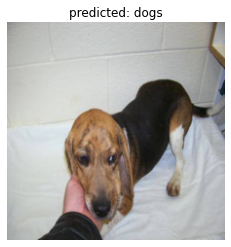

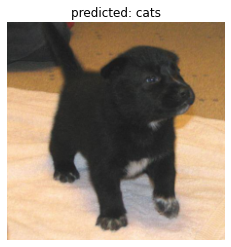

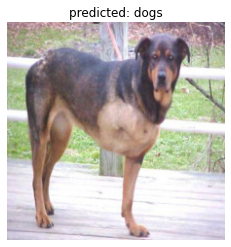

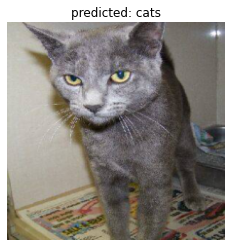

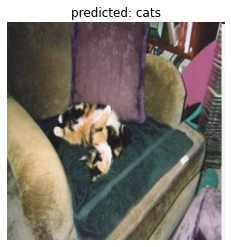

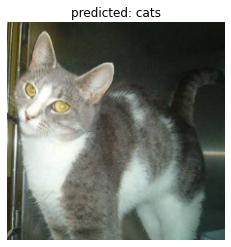

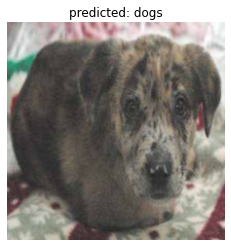

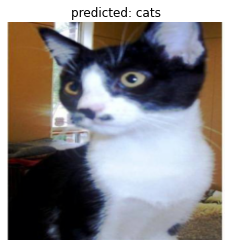

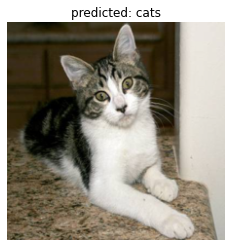

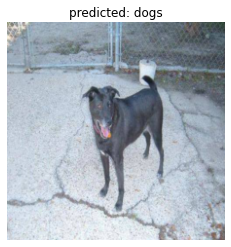

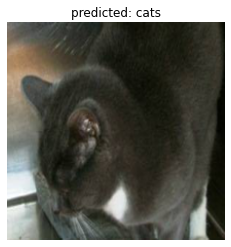

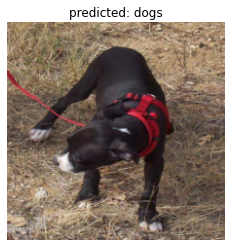

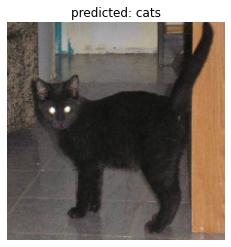

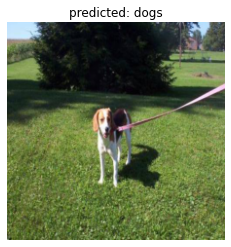

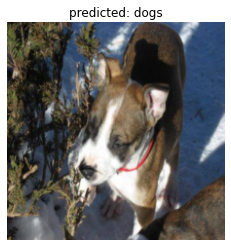

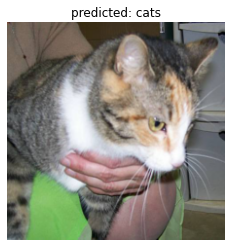

In [17]:
def visualize_model(model_conv, num_images=24):
    was_training = model_conv.training
    model_conv.eval()
    images_so_far = 0
    fig = plt.figure()
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            
    outputs = model_conv(inputs)
    _, preds = torch.max(outputs, 1)
    for j in range(inputs.size()[0]):
        images_so_far += 1
        ax = plt.subplot()
        ax.axis('off')
        ax.set_title('predicted: {}'.format(class_names[preds[j]]))
        imshow(inputs.cpu().data[j])
        if images_so_far == num_images:
            model_conv.train(mode=was_training)
            return
    model_conv.train(mode=was_training)
visualize_model(model_conv)
plt.ioff()
plt.show()